# Домашнее задание №3
Домашнее задание включает в себя следующие пункты:
1. Написать собственную свертку
2. Написать модуль батч нормализации для картинок
3. Написать модули для оптимизации SGD+momentum, Adam
4. Построить графики и обучения и сделать выводы по сравнению обучения 
    * SGD+momentum, Adam
    
Адрес для посылки ДЗ mfti_2018_hw03@mail.ru

# Требуемые модули:
Python 3.6
1. pytorch=0.41 // [инструкция по установке](https://pytorch.org/get-started/previous-versions/)
2. torchvision=0.2.2.post3 // pip install ...
3. matplotlib  //
4. PIL=5.4.1
5. scipy=1.1.0
6. numpy=1.15.14
7. pickle

# Требования
1. Присылаем этот ноутбук только с полностью выполненными заданиями.
2. Файл должен называть MFTI_2019_hw03_ФАМИЛИЯ_ИМЯ.ipynb
3. Заданние должно быть выполнено до 24.03.2019 до 23:59.
4. После проверки у Вас будет одна попытка для исправления замечаний. 

# 1. Реализация собственной свертки
В этом пункте Вам нужно реализовать модуль необучаемой свертки 2D. Используем только библиотеку <font collor='red'>__pytorch__</font>. Получаем на вход тензор размером $(C_{in}, H, W)$, на выходе получаем тензор $(C_{out}, H_{out}, W_{out})$.
$$
H - высота. \\
W - ширина. \\
С - количество\ каналов \\
$$
Реализуем операцию свертки с параметрами:

$\large k $ - ядро свертки, тензор с парамерами $C_{in}, H_k, W_k,$ <br>
$stride_{H,W}$ - шаг ядра свертки, <br>
$padding_{H,W} $ - размер паддинга.

Формулы расчета размера выходной картинки
$$
\begin{align}\begin{aligned}H_{out} = \left\lfloor\frac{H_{in}  + 2 \times \text{padding}_H- \text{kernel_size}_H}{\text{stride}_H} + 1\right\rfloor\\W_{out} = \left\lfloor\frac{W_{in}  + 2 \times \text{padding}_W - \text{kernel_size}_W}{\text{stride}_W} + 1\right\rfloor\end{aligned}\end{align}
$$
Графическое представление 2D свертки
### Представление свертки
Параметры: kernel=3x3, padding=0,0
<img src="./imgs/18.jpg">

### Stride
Параметры: kernel=2x2, padding=0,0, stride=2,2
<img src="./imgs/22.gif" width=300>

### Padding
Параметры: kernel=2x2, padding=1,1, stride=1,1
<img src="./imgs/23.gif" width=400>



### Для проверки работоспособности сверки можно использовать 

```python 
from torch.nn.functional import conv2d
```
### Добавление дополнительной размерности в тензор
B - размер батча в нашем случае 1, размер картинки $C\times H \times W$. Для добавления и схлопывания размерностей используем
  - squeeze() - убирает размерность
  - unsqueeze() - добавляет размерность

In [1]:
# прототип функции 
def my_conv2d(x,
              kernel,
              stride=(1,1), padding=(0,0), bias=None):
    """
    Arguments:
    :param  x: входной тензор 4d, тип tensor.FloatTensor, размерность BxCxHxW
    :param  kernel: входной тензор ядра 3d, тип tensor.FloatTensor, CxHxW
    :param  stride: tuple - параметры страйда, задаются в формате HxW
    :param  padding:  tuple - параметры паддинга, задаются в формате HxW
    :param  bias : входной тензор bias добавляется к выходному тензору.  
    """
    
    H_out = int((x.shape[1] + 2*padding[0] - kernel.shape[1])/stride[0] + 1)
    W_out = int((x.shape[2] + 2*padding[1] - kernel.shape[2])/stride[1] + 1)
    
    x_out = torch.zeros((H_out, W_out))
    fill_to_size = torch.nn.ConstantPad2d((padding[0], padding[0], padding[1], padding[1]), 0)
    x_in = fill_to_size(x)
    
    for i in range(H_out):
        for j in range(W_out):
            cur_area = x_in[:,i*stride[0]:i*stride[0]+kernel.shape[1], j*stride[1]:j*stride[1]+kernel.shape[2]]
            mult = torch.mul(cur_area, kernel)
            cur_sum = torch.sum(mult)
            if bias != None:
                cur_sum += bias
            x_out[i, j] = cur_sum.squeeze()
    
    print(x_out.shape)

    return x_out

#from my_conv2d import my_conv2d

In [2]:
# функции тестирования
from tests_functions import * 

### Загружаем картинку 

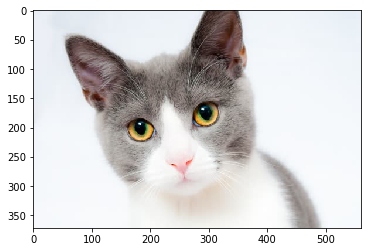

In [3]:
import torch
import torchvision as tv

# библиотека для отрисовки графиков, картинок .... 
import matplotlib.pyplot as plt
%matplotlib inline

# загрузка изображений
from PIL import Image
cat_convolve= Image.open('./imgs/cat_convolve.jpg')
plt.imshow(cat_convolve)

### Превращаем кота в тензор

In [4]:
cat_tensor = tv.transforms.ToTensor()(cat_convolve)
print (cat_tensor.size())

torch.Size([3, 372, 560])


### Сворачиваем картинку ядром, детектор границ
$$
\begin{bmatrix}
    -1       & -1 & -1  \\
    -1       & 8 & -1 \\
    -1       & -1 & -1
\end{bmatrix}
$$

### Создаем фильтр ядра и заполняем его -1 & 8

In [5]:
filter_kernel = torch.FloatTensor(3,3,3).fill_(-1)
filter_kernel[:,1,1] = 8
print(filter_kernel.size())

torch.Size([3, 3, 3])


### Делаем свертку картинки ядром

torch.Size([370, 558])
torch.Size([370, 558])


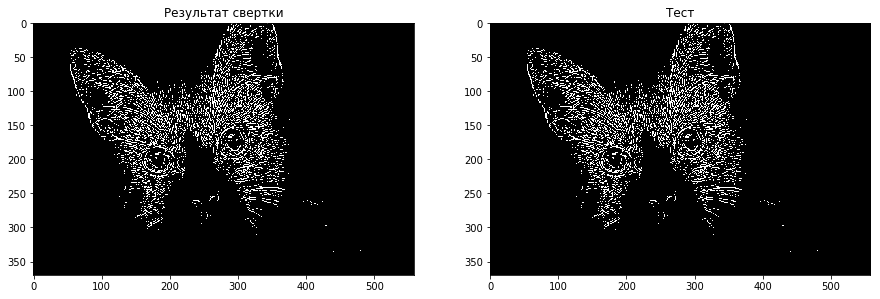

In [6]:
o_image = my_conv2d(cat_tensor, filter_kernel)
o_image[o_image >= 0.5] = 1  # бустим границы
o_image[o_image < 0.5] = 0
test_conv(o_image, './data/kernel_01.pth')

### Горизонтальные границы
$$
\begin{bmatrix}
    1       & 1 & 1  \\
    0       & 0 & 0 \\
    -1       & -1 & -1
\end{bmatrix}
$$

In [7]:
filter_kernel = torch.FloatTensor(3,3,3).fill_(1)
filter_kernel[:,1,:] = 0
filter_kernel[:,2,:] = -1
print(filter_kernel.size())

torch.Size([3, 3, 3])


torch.Size([370, 558])
torch.Size([370, 558])


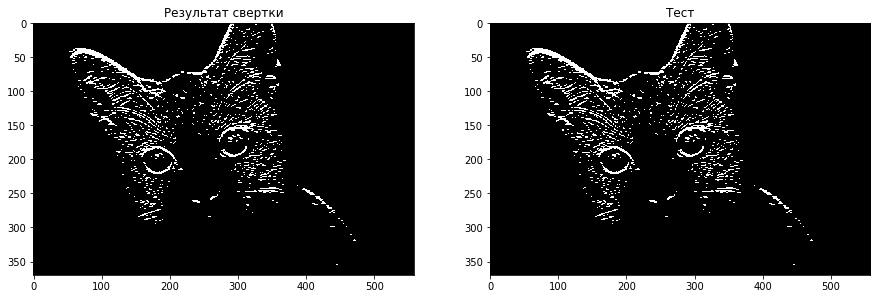

In [8]:
o_image = my_conv2d(cat_tensor, filter_kernel)
o_image[o_image >= 0.5] = 1  # бустим границы
o_image[o_image < 0.5] = 0
test_conv(o_image, './data/kernel_02.pth')

### Вертикальные границы
$$
\begin{bmatrix}
    1       & 0 & -1  \\
    1       & 0 & -1 \\
    1       & 0 & -1
\end{bmatrix}
$$

In [9]:
filter_kernel = torch.FloatTensor(3,3,3).fill_(1)
filter_kernel[:,:,1] = 0
filter_kernel[:,:,2] = -1
print(filter_kernel.size())

torch.Size([3, 3, 3])


torch.Size([370, 558])
torch.Size([370, 558])


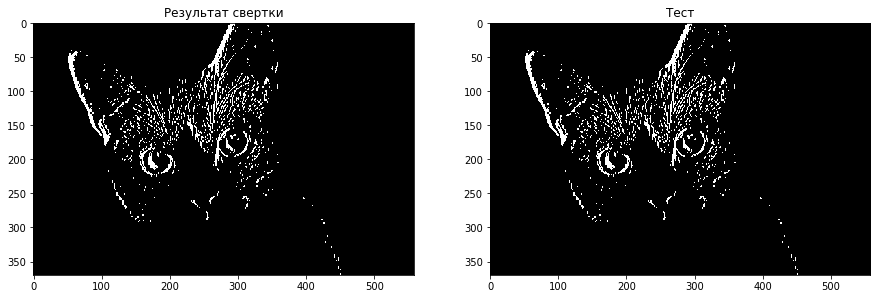

In [10]:
o_image = my_conv2d(cat_tensor, filter_kernel)
o_image[o_image >= 0.5] = 1  # бустим границы
o_image[o_image < 0.5] = 0
test_conv(o_image, './data/kernel_03.pth')

### Используем ядро 

$$ \begin{bmatrix}
    1 & 1 \\
    1 & 1
\end{bmatrix}$$

### и stride 2

torch.Size([186, 280])
torch.Size([186, 280])
torch.Size([186, 280])


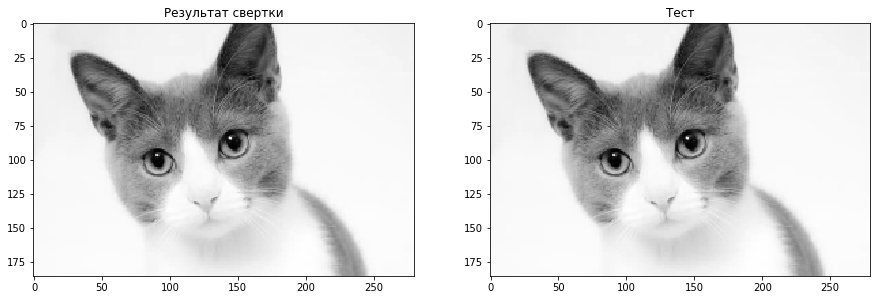

In [11]:
filter_kernelx2 = torch.FloatTensor(3,2,2).fill_(1)
o_image = my_conv2d(cat_tensor, filter_kernelx2, stride=(2,2))
o_image /= 4 # усредняем
#torch.save(o_image, './data/kernel_05.pth') # тут проверочный выход читанем его
test_conv(o_image, './data/kernel_05.pth')
assert o_image.size() == torch.Size([186, 280]), 'Размер выходного изображения не совпадает с размером теста'
print(o_image.size())
plt.imshow(o_image.numpy(), cmap='gray')

### Используем ядро 

$$ \begin{bmatrix}
    1 & 1 & 1 \\
    1 & 1 & 1 \\
    1 & 1 & 1
\end{bmatrix}$$

### и stride 1, padding 1

torch.Size([372, 560])
torch.Size([372, 560])


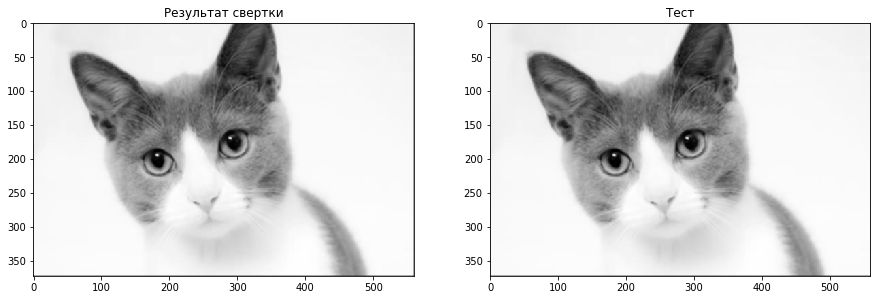

In [12]:
filter_kernelx2 = torch.FloatTensor(3,3,3).fill_(1)
o_image = my_conv2d(cat_tensor, filter_kernelx2, stride=(1,1), padding=(1,1))
o_image /= 4 # усредняем
#torch.save(o_image, './data/kernel_04.pth') # тут проверочный выход читанем его
test_conv(o_image, './data/kernel_04.pth')

### Используем ядро 

$$ \begin{bmatrix}
    1 & 1 & 1 \\
    1 & 1 & 1 \\
    1 & 1 & 1
\end{bmatrix}$$

### и stride 2, padding 2

torch.Size([187, 281])
torch.Size([187, 281])


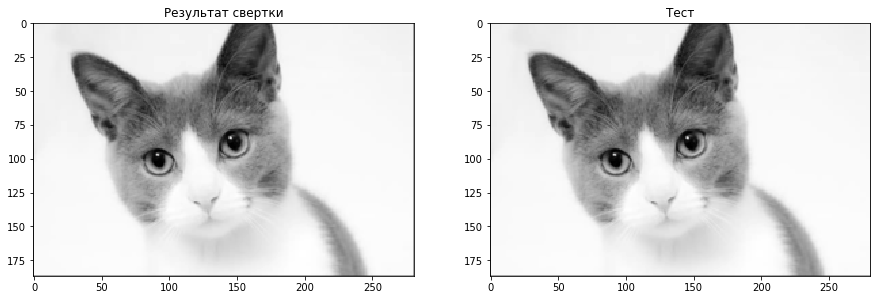

In [13]:
filter_kernelx2 = torch.FloatTensor(3,3,3).fill_(1)
o_image = my_conv2d(cat_tensor, filter_kernelx2, stride=(2,2), padding=(2,2))
o_image /= 4 # усредняем
test_conv(o_image, './data/kernel_06.pth')

### Ядро свертки с гаусовым распределением

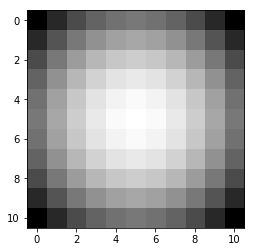

In [14]:
import scipy.ndimage as ndi
import numpy as np
sigma = 10    # параметр распределение
patern_size = 101 # максимальный размер ядра свертки
kernel_size = 10  # реальный размер свертки
x = np.zeros((patern_size, patern_size))
x [patern_size//2,patern_size//2]= 1

# делаем ядро с гаусовым распределением
gause_kernel = ndi.filters.gaussian_filter(x, sigma=sigma)
# вырезаем из центра наш кернел
gause_kernel = gause_kernel[(patern_size//2-(kernel_size//2)):(patern_size//2+(kernel_size//2))+1, \
                (patern_size//2-(kernel_size//2)):(patern_size//2+(kernel_size//2))+1]
# вот он
plt.imshow(gause_kernel, interpolation='none', cmap=plt.get_cmap('gray'))

# Делаем сверку 

torch.Size([362, 550])
torch.Size([362, 550])


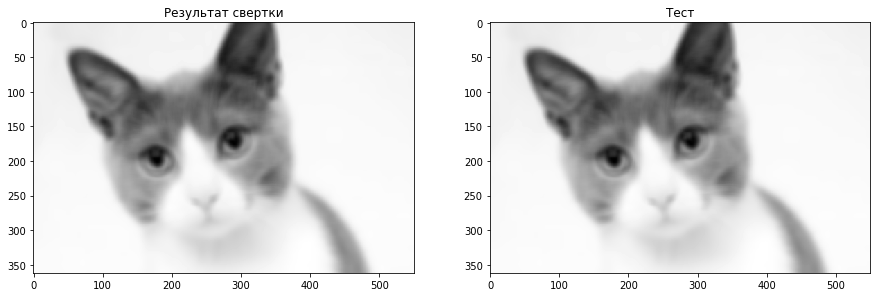

In [15]:
o_image = my_conv2d(cat_tensor, torch.from_numpy(gause_kernel).float().unsqueeze(0))
test_conv(o_image, './data/kernel_07.pth', False)

# Написать модуль батч нормализации для картинок
<img src="./imgs/37.png" width=400>

- Как выглядит формула финальной батч нормализации в слое при прямом проходе в процессе тренеровки сети, используем формулу для экспоненциального скользящего среднего:
$$
\large
\begin{align}
v_t = \beta \times v_{t-1} + (1-\beta)\times \mu_t \leftarrow для \ каждой \ ФИЧИ \ в \ батче \ расчитываем \ ее \ среднее \\ 
s_t = \beta \times s_{t-1} + (1-\beta)\times \sigma^2_t \leftarrow для \ каждой \ ФИЧИ \ в \ батче \ расчитываем \ ее \ дисперсию \\ \\
\hat{\mathbf{x}} = \frac{\mathbf{x_t} - \mu}{ \sqrt{\sigma^2 + \epsilon}} \times \gamma + b \leftarrow финальная \ формула \ для \ расчета  \ выхода\ слоя \ в \ режиме\ тренировки
\end{align}
$$

где $ \large \gamma, b $ - параметры, афинного преобразования, размерность - количество фичей во входном тензоре, эти параметры обучаются вместе с батч нормализацией

- Как выглядит правило для расчета выхода в процессе инференса:
$$
\large
\begin{align}
\hat{\mathbf{x}} = \frac{\mathbf{x_t} - v_t}{ \sqrt{s_t + \epsilon}} \times \gamma + b \leftarrow финальная \ формула \ для \ расчета  \ выхода\ слоя
\end{align}
$$

$\large s_t, v_t, \\ параметры считаются в процессе тренировки
\gamma, b $ - обучаемые параметры параметры.

### Задание:
Реализовать модуль 2d батч нормализации и проверить его работу на входных изображениях.

P.S. Каждый канал входной картинки считается отдельной фичёй (компонентом векторов)

Нужные функции
```python
import torch
torch.zeros - создать тензор заполненный нулями
torch.ones - создать тензор заполненный единицами
torch.Tensor - создать тензор(1, in_channels, 1, 1)
torch.mean, torch.var  - среднее и дисперсия
x.uniform_ - заполнить тензор случайными числами из равномерного распределения
y.expand_as(x) - разширить тензор y до размера x, по расширяемым направлениям размерность тензора x должна быть равна 1
x.unsqueeze(dim) - добавить размерность в тензор
x.squeeze - убрать размерность

```

### <font color=red>Важно</font> 
Код батч нормализации должен быть максимально простым, _циклы_ в нем не нужны. Используйте встроенные функции torch view, mean, var, unsqueeze, expand_as

In [16]:
import torch.nn as nn

 
class BatchNorm2d(nn.Module):
   
    def __init__(self, in_channels, afine=True, beta=0.9, epsilon=1e-8):
        """
        Инициализация BN
        Если задан флаг afine, то должны быть проинициализированны матрицы гамма и b
        для осуществления афинных преобразований в процессе тренировки и теста.
        Обучаемый параметры устанавливаем как тензора соответсвующей размерности и сохраняем
        их
        self.weight
        self.bias
        В данном ДЗ мы не обучаем эти параметры, лишь реализуем саму концепцию.
       
        !!! чтобы проходил последний тест на картинках мниста нужно инициализировть beta & epsilon из аргументов
       
       :param in_channels: количество входных каналов предыдущего слоя
       :param afine: делать ли афинное преобразование в процессе обучения.
       :param beta: параметр сглаживания
       :param epsilon: параметр исключающий деление на ноль
       """
        super().__init__()
        self.afine = afine
        self.beta = beta
        self.epsilon = epsilon
        self.in_channels = in_channels
       

        self.weight = torch.zeros(in_channels, 1, 1).uniform_()
        self.bias = torch.zeros(in_channels, 1, 1)
    
        self.runing_mean = torch.zeros(in_channels)
        self.runing_var = torch.ones(in_channels)
        
        self.training = True
       
    def forward(self, x):
        """
       Считаем параметры нормализации в режиме обучения, и нормализуем x в обоих режимах
       используем для расчета праметры gamma и b КАК обучаемые, т.е. учитываем,
       что эти параметры должны быть обучены в процессе тренировки.
       """
        
        if self.training:
          # находимся в режиме обучения
            size = x.shape
            
            x_prep = x.reshape(size[0], size[1], size[2] * size[3]).permute(1, 0, 2).reshape(size[1], size[2] * size[3] * size[0])
            
            mean = torch.mean(x_prep, dim=1)
            var = torch.var(x_prep, dim=1)
                                  
            self.runing_mean = self.beta * self.runing_mean + (1 - self.beta) * mean
            self.runing_var = self.beta * self.runing_var + (1 - self.beta) * var
            
            x_batch = (x - mean.reshape(1, mean.shape[0], 1, 1).expand(size))/torch.sqrt(var.reshape(1, var.shape[0], 1, 1).expand(size) + self.epsilon)
            
        else:
            x_batch = (x - self.runing_mean)/torch.sqrt(self.runing_var + self.epsilon)

        if self.afine == True:
            x_batch = x_batch * self.weight + self.bias
            
        return x_batch

### Проверяем работу батч нормадлизации на котэ

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([372, 560, 3])


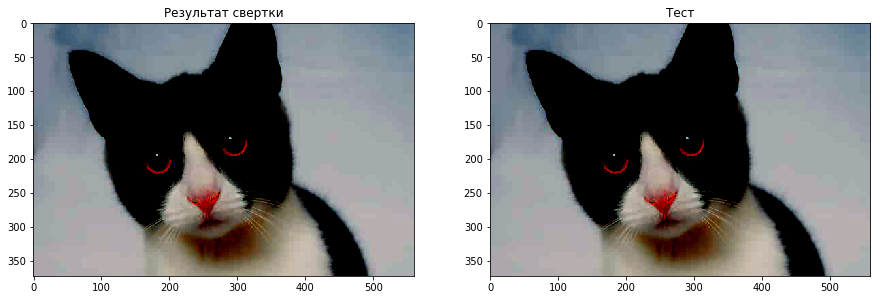

In [17]:
# Без афинных преобразований, за один проход не должно быть значительных изменений, потому что начальные значеня среднего 0 
# и дисперсии 1 
bn = BatchNorm2d(3, afine=False)
assert bn.training # проверяем, что сеть находится в режиме тренировки
# добавляем размерность батча
o_image = bn(cat_tensor.unsqueeze(0))
# убираем размерность батча
o_image = o_image.squeeze()
# транспонирование тензора картинки картинки
# для того, чтобы его мог отрисовать matplot
o_image = o_image.transpose(0,2).transpose(0,1)
assert bn.runing_mean.size()[0] == 3 and bn.runing_var.size()[0] == 3,  "Размерности  runing_mean & runing_var должны совпадать с количеством входных каналов"
assert bn.runing_mean[0] != bn.runing_mean[1],  "Странно, что у вас совпадают значения средних по каналам"
test_conv(o_image, './data/bn_01.pth')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([372, 560, 3])


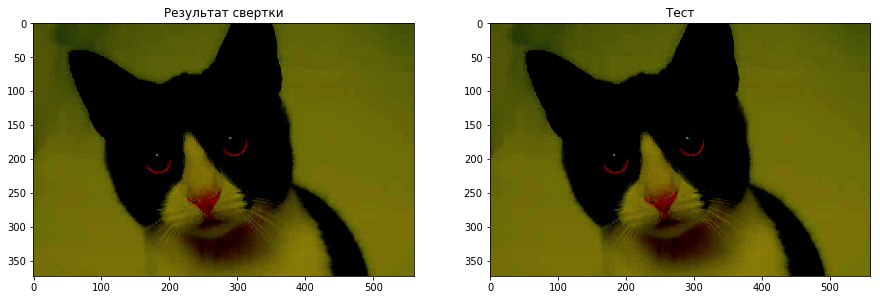

In [31]:
# C афинными преобразованиями, должен нагладыватья uniform_ шум при каждом новом запуске
# Поэтому, чтобы получить детерменированный результат устанавливаем seed
# !!! Если Вы делаете перезапуск последующих тестов по BN, то их нужно делать с этого места, 
# иначе тесты могут не проходить.
torch.manual_seed(999)

bn = BatchNorm2d(3, afine=True)
assert bn.training # проверяем, что сеть находится в режиме тренировки
# добавляем размерность батча
o_image = bn(cat_tensor.unsqueeze(0))
# убираем размерность батча
o_image = o_image.squeeze()
# транспонирование тензора картинки картинки
# для того, чтобы его мог отрисовать matplot
o_image = o_image.transpose(0,2).transpose(0,1)
test_conv(o_image, './data/bn_02.pth')
#print (o_image.size())

### Проверим как реализация работает на большом сете картинок
Цель проверить расчет running_mean and running_var, эти переменные мы расчитываем в режиме тренировки

In [32]:
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline

In [33]:
# Загружаем MNIST
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original', data_home='./')
X = mnist['data']
# переходим к формату тензоров pytorch
X = X.reshape((-1, 1, 28, 28))
X = X.astype('float')
print(X.shape)

/usr/local/lib/python3.7/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function fetch_mldata is deprecated; fetch_mldata was deprecated in version 0.20 and will be removed in version 0.22
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function mldata_filename is deprecated; mldata_filename was deprecated in version 0.20 and will be removed in version 0.22
  warnings.warn(msg, category=DeprecationWarning)


(70000, 1, 28, 28)


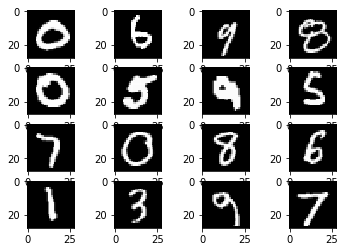

In [34]:
n=4
for i in range(n*n):
    plt.subplot(n,n,i+1)
    I = X[np.random.randint(0, X.shape[0]),0]
    plt.imshow(I, cmap='gray')

### Тестируем модуль батч нормализации на мнисте
Прогоняем весь поток картинок (1 эпоха) с размером батча 32, и смотрим как расчитываются скользящее среднее значение в процессе тренировки

In [35]:
# функция тестирования BN
def test_batch_norm(bn):
    bn.train(True)
    # количество эпох и размер батча
    c_epoch = 1
    batch_size = 32
    # данные для отчета
    mean_curve = []
    var_curve = []
    np.random.seed(999)
    for iter in range(c_epoch):
        Xperm = np.random.permutation(X.shape[0])
        loss_acc = 0
        nbatches = X.shape[0]//batch_size
        for b in range(nbatches):
            batch_idxs = Xperm[b*batch_size:(b+1)*batch_size]
            x = torch.Tensor(X[batch_idxs])
            bn(x)
            mean_curve += [ bn.runing_mean ] 
            var_curve +=  [ bn.runing_var ]
    return mean_curve, var_curve

In [36]:
# параметры beta = 0.9, 0.99, 0.5
bn_09 = BatchNorm2d(1, beta=0.9)
bn_099 = BatchNorm2d(1, beta=0.99)
bn_05 = BatchNorm2d(1, beta=0.5)
# ставим обучение в True
bn.train(True)
# количество эпох и размер батча
c_epoch = 1
batch_size = 32
# данные для отчета
mean_curve_09, var_curve_09 = test_batch_norm(bn_09)
mean_curve_099, var_curve_099 = test_batch_norm(bn_099)
mean_curve_05, var_curve_05 = test_batch_norm(bn_05)

BN beta=09


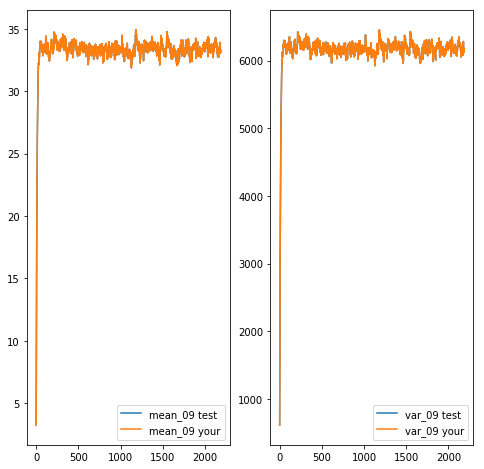

In [37]:
print ("BN beta=09")
test_bn_plots(mean_curve_09, var_curve_09, '09')

BN beta=099


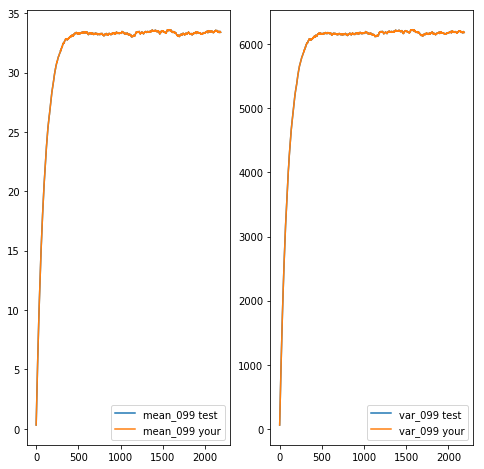

In [38]:
print ("BN beta=099")
test_bn_plots(mean_curve_099, var_curve_099, '099')

BN beta=05


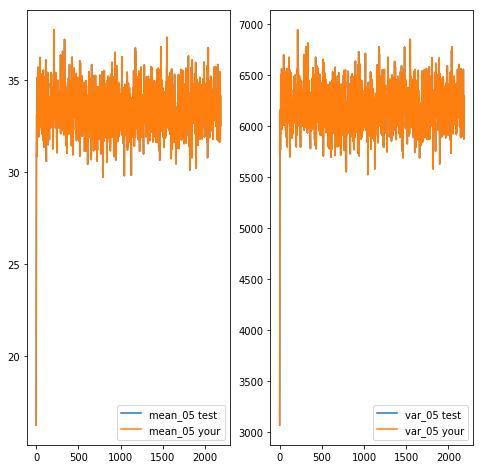

In [39]:
print ("BN beta=05")
test_bn_plots(mean_curve_05, var_curve_05, '05')

Смотрим какие значения средних и дисперсий у нас получились

In [40]:
print ("Проверим, что правильно посчитали среднее и дисперсию при одинаковом seed")
assert int(bn_09.runing_mean[0]) == 33
assert int(bn_099.runing_mean[0]) == 33
assert int(bn_05.runing_mean[0]) == 32
assert int(bn_09.runing_var[0]) == 6136
assert int(bn_099.runing_var[0]) == 6180
assert int(bn_05.runing_var[0]) == 6038
print ('ok')

Проверим, что правильно посчитали среднее и дисперсию при одинаковом seed
ok


Посмотрим как повлияла батч нормализация на изображения

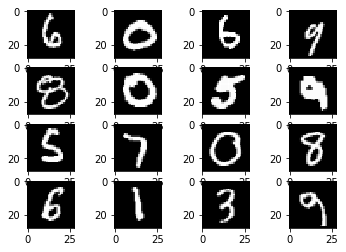

In [41]:
n=4
bn = bn_09
bn.train(False) # эмулируем режим тестирования
np.random.seed(666)
for i in range(n*n):
    plt.subplot(n,n,i+1)
    I = X[np.random.randint(0, X.shape[0]),0]
    x = torch.Tensor(I)
    I = bn(x.unsqueeze(0)).squeeze(0).squeeze()
    # загрузим сохраненный тестовый тензор 
    t_I = torch.load('./data/bn_minst_%2d.pth'%i)
    # проверим, что нормализованный и тестовый тензор совпадают 
    assert (I == t_I).all(), "Что-то не так нормализованный тензор и тестовый не совпадают"
    plt.imshow(I, cmap='gray')

## Done

# Реализуем свой Adam и SGD c моментом

Для реализации своего алгоритма оптимизации в pytorch нужно отнаслеловаться от базового класса Optimizer. При начальной инициализации алгоритма оптимизации он получает в качестве параматра все веса сети. Веса сети можно молучить через 
net.parameters(). По весам сети расчитывается градиент в функции loss.backward(). Веса сети организуются в группы, 
каждая группа образует словарь с сохраненными параметрами обучения, задаются в конструкторе, и самими параметрами, которые доступны по ключу "params". Параметры сети описываются классом Parameters. Для доступа к градиентам используется свойство grad.
Это тензор. Для сохранения параметров оптимизатор имеет свойство state, которое является словарем. Используется для
хранения промежуточных значений средних, дисперсий между шагами итераций.

**Задача** - реализовать функци step() для SGD и Adam, сравнить кривые обучения в зависимости от гиперпараметров (коэффициент обучения, betas), построить графики для различных параметров для каждого алгоритма, сделать выводы о скорости сходимости


## Adam (Adaptive Moment Estimation) 

Adam = SGD + Momentum + RMSProp

$$
\large
\begin{align}
m_t &= \alpha \ m_{t-1} + (1 - \alpha)\ g - момент \\ 
v_t &= \beta \ v_{t-1} +  (1-\beta)\ g_{t}^2  - скользящее\ среднее \ по \ квадрату \ градиента \\
\\
\hat{m_t} &= \frac{m_t}{1 - \alpha^t}\\
\hat{v_t} &= \frac{v_t}{1 - \beta^t}\\
\theta_t &= \theta_{t-1} -  \frac{\lambda}{\sqrt{\hat{v_t} + \epsilon}}\hat{m_t} \\
\ выразим\ step\_size \ через \ \alpha \ и \ \beta \\
\ step\_size =  \lambda \frac {({1 - \beta^t})^{\frac{1}{2}}}{{1 - \alpha^t}} \\ 
\theta_t &= \theta_{t-1} -  \frac{step\_size}{\sqrt{v_t + \epsilon}}\times m_t 
\end{align}
$$


In [42]:
from torch.optim import Optimizer
import math

class Adam(Optimizer):
    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8):
        """
        :param params: - параметры оптимизируемой сети
        :param betas: - коэффициенты сглаживания
        :param eps: - 
        """
        defaults = dict(lr=lr, betas=betas, eps=eps)
        # тут вызываем конструктор базового класса и сохраняем параметры обучения
        # их можно достать через self.param_groups
        super(Adam, self).__init__(params, defaults)

    def step(self):
        """
        Выполняем оптимизационный шаг
        """
        loss = None

        for group in self.param_groups:
            # итерируемся по всем группам параметров нашей сети
            # тут можно вытащить сохраненные параметры в группе
            beta1, beta2 = group['betas'] 
            eps = group['eps']
            lr = group['lr']
            for p in group['params']:
                # итерируемся по всем парамерам в данно группе
                # если нет градиента по параметрам скипаем его
                if p.grad is None:
                    continue
                # забираем тензор градиента    
                grad = p.grad.data
                
                # тут храняться значения, которые мы расчитываем в процессе 
                # по каждому параметру в группе нужно расчитывать свои значения
                state = self.state[p]

                # если параметры мы еще не записали инициализируем их значения
                if len(state) == 0:
                    state['step'] = 0
                    # скользящее среднее по градинтам
                    state['exp_avg'] = torch.zeros_like(p.data)
                    # скользящее среднее по квадрату градиентов
                    state['exp_avg_sq'] = torch.zeros_like(p.data)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                        
                # запоминаем шаг
                state['step'] += 1

                # Считаем параметры. Записывать обратно в state не нужно, ибо мы получаем ссылку
                # TODO
                exp_avg.mul_(beta1).add_(1 - beta1, grad)
                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)
                

                # обновляем веса в p.data, 
                # TODO
                step = state['step']
                step_size = lr*np.sqrt(1-beta2**step)/(1-beta1**step)
                p.data.addcdiv_(-step_size, exp_avg, exp_avg_sq.add_(eps).sqrt())

                
        return loss

## SGD + Momentum
$$
\Large
\begin{align}
g_t &= \nabla_{\theta} \overset{\wedge}{\large J}\left(x,y,\theta \right) - градиент \\
m_t &= \beta m_{t-1} - (1- \beta) g_t, \ где \  \beta - параметр\ обучения \\
m_t &= \alpha m_{t-1} - \lambda g_t, \ альтернативная \ форма \ записи \\
\theta_t &= \theta_{t-1} + m_t
\end{align}
$$

In [43]:

class SGD(Optimizer):
    def __init__(self, params, lr, beta=0.9):
        """
        :param params: - параметры оптимизируемой сети
        :param beta: - коэффициент сглаживания
        :param eps: - 
        """        
        defaults = dict(lr=lr, beta=beta)
        # тут вызываем конструктор базового класса и сохраняем параметры обучения
        # их можно достать через self.param_groups 
        super(SGD, self).__init__(params, defaults)

    def step(self):
        """
        Выполняем оптимизационный шаг
        """

        loss = None

        for group in self.param_groups:
            # итерируемся по всем группам параметров нашей сети
            # тут можно вытащить сохраненные параметры в группе            
            beta = group['beta']
            lr = group['lr']
            for p in group['params']:
                if p.grad is None:
                    continue
                    
                d_p = p.grad.data
                state = self.state[p]
                if len(state) == 0:
                    state['exp_avg'] = d_p
                
                exp_avg=state['exp_avg']
                if beta != 0:
                    # тут добавляем момент если он указан
                    # todo
                    exp_avg.mul_(beta).add_(1-beta, d_p)

                # обновляем веса
                # to do
                p.data.add_(-lr, exp_avg)


        return loss


Тут векторизуем наш выход как OneHotEncoder вектор. Если объект принадлежит классу значение 1 нет 0.

In [44]:
from sklearn.preprocessing import OneHotEncoder

Y = mnist['target'].astype('int')
print('original', Y)


original [0 0 0 ... 9 9 9]


In [45]:
USE_CUDA=False

## Определение нашей модели
Параметры инициализации
- Без параметров - конволюции и активации
- dropout = True - c dropout
- batchnorm = True - включаем  batch normalization

In [46]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):

    # Слои, в которых нет параметров для обучения можно не создавать, а брать из переменной F
    def __init__(self, dropout=False, batchnorm=False):
        super(Net, self).__init__()
        #
        # спецальный модуль, который позволяет 
        # объединять компоненты
        self.net = nn.Sequential(nn.BatchNorm2d(1))
        
        # вход 28x28, выход 24x24 (28-5)/1 + 1 = 24
        self.net.add_module('conv_1', nn.Conv2d(1, 8, kernel_size=5, stride=1))
        # добавляем бн
        if batchnorm: self.net.add_module('bn_1', nn.BatchNorm2d(8))
        self.net.add_module('relu_1', nn.ReLU())  
        
        # добавляем дропаут
        if dropout: self.net.add_module('do_1', nn.Dropout(0.5))            
        
        # конволюция, которая уменьшает размер картинки в два раза 
        # (24-2)/2+1 = 12, либо используем nn.MaxPool2d
        self.net.add_module('pool_1', nn.Conv2d(8, 8, kernel_size=2, stride=2)) 
        
        # далее conv->relu->pool
        self.net.add_module('conv_2', nn.Conv2d(8, 16, 5)) # in 12x12, out 8x8
        # добавляем бн
        if batchnorm: self.net.add_module('bn_2', nn.BatchNorm2d(16))
        self.net.add_module('relu_2', nn.ReLU() ) 
        
        # добавляем дропаут
        if dropout: self.net.add_module('do_2', nn.Dropout(0.5))
            
        self.net.add_module('pool_2', nn.MaxPool2d(kernel_size=2, stride=2))
        # Линейный слой классификатора
        self.fc1 = nn.Linear(16 * 4 * 4, 10)
        # relu

    def forward(self, x):
        x = self.net(x)
        # Вытягиваем многомерный тензор катринки в одну линию
        x = x.view(-1, 16 * 4 * 4)
        x = self.fc1(x)
        return x

## Функция обучения модели

In [50]:
def fit_net(c_epoch, network, optimizer):
    loss_fn = torch.nn.CrossEntropyLoss()
    if USE_CUDA:
        loss_fn = loss_fn.cuda()

    batch_size = 32
    loss_curve = []

    for iter in range(c_epoch):
        Xperm = np.random.permutation(X.shape[0])
        loss_acc = 0
        nbatches = X.shape[0]//batch_size
        for b in range(nbatches):
            optimizer.zero_grad()  
            batch_idxs = Xperm[b*batch_size:(b+1)*batch_size]
            x = torch.Tensor(X[batch_idxs])
            y = torch.from_numpy(Y[batch_idxs]).long()
            if USE_CUDA:
                x = x.cuda()
                y = y.cuda()
            y_pred = network(x)
            loss = loss_fn(y_pred, y)
            loss_acc += float( loss.item() )
            loss.backward()
            optimizer.step()  
        avg_epoch_loss = loss_acc / (nbatches)
        print('Do epoch %s with loss %s' % (iter, avg_epoch_loss ))
        loss_curve.append(avg_epoch_loss)
    
    return loss_curve

## SGD без момента

In [51]:
learning_rate = 1e-1 # 
net = Net(batchnorm=True)
net = net.cuda() if USE_CUDA else net
optimizer = SGD(net.parameters(), lr=learning_rate, beta=0.0)
loss_curve_sgd = fit_net(20, net, optimizer)

Do epoch 0 with loss 0.11945552605101656
Do epoch 1 with loss 0.05135116576773694
Do epoch 2 with loss 0.04055345656667935
Do epoch 3 with loss 0.034721051884885785
Do epoch 4 with loss 0.030291341742561134
Do epoch 5 with loss 0.027241809067929997
Do epoch 6 with loss 0.024097270554993652
Do epoch 7 with loss 0.022065412653435514
Do epoch 8 with loss 0.02010311173367947
Do epoch 9 with loss 0.017929818888314523
Do epoch 10 with loss 0.016742209177830474
Do epoch 11 with loss 0.015262445008231451
Do epoch 12 with loss 0.01468139876295128
Do epoch 13 with loss 0.013170284008292996
Do epoch 14 with loss 0.011386349378217558
Do epoch 15 with loss 0.010926653529254607
Do epoch 16 with loss 0.010859562604461132
Do epoch 17 with loss 0.009427227437577948
Do epoch 18 with loss 0.008896696135558437
Do epoch 19 with loss 0.008311730789495049


## SGD с моментом

In [52]:
learning_rate = 1e-1
net = Net(batchnorm=True)
net = net.cuda() if USE_CUDA else net
optimizer = SGD(net.parameters(), lr=learning_rate, beta=0.9)
loss_curve_sgd_momentum = fit_net(20, net, optimizer)

Do epoch 0 with loss 0.12485342538882785
Do epoch 1 with loss 0.05444139267041578
Do epoch 2 with loss 0.043063087772985106
Do epoch 3 with loss 0.036572599857636764
Do epoch 4 with loss 0.031196950677191224
Do epoch 5 with loss 0.027941444385362425
Do epoch 6 with loss 0.02567483135552291
Do epoch 7 with loss 0.023513922420984868
Do epoch 8 with loss 0.02121537143494857
Do epoch 9 with loss 0.0193591999596093
Do epoch 10 with loss 0.017569393873432756
Do epoch 11 with loss 0.016175384660071308
Do epoch 12 with loss 0.014704746995197892
Do epoch 13 with loss 0.01397818090521041
Do epoch 14 with loss 0.013355258199849193
Do epoch 15 with loss 0.012323856837519458
Do epoch 16 with loss 0.010272750795350862
Do epoch 17 with loss 0.01083331998347364
Do epoch 18 with loss 0.009850115803588619
Do epoch 19 with loss 0.008858546761137523


## Adam

In [53]:
learning_rate = 1e-3
net = Net(batchnorm=True)
net = net.cuda() if USE_CUDA else net
optimizer = Adam(net.parameters(), lr=learning_rate, betas=(0.9, 0.999))
loss_curve_adam = fit_net(20, net, optimizer)

Do epoch 0 with loss 0.19151349207126608
Do epoch 1 with loss 0.05632193595814852
Do epoch 2 with loss 0.043604742510352415
Do epoch 3 with loss 0.03709803276772389
Do epoch 4 with loss 0.031114782542066934
Do epoch 5 with loss 0.02878168011503656
Do epoch 6 with loss 0.025431076652584594
Do epoch 7 with loss 0.023183030067382197
Do epoch 8 with loss 0.021477691094728742
Do epoch 9 with loss 0.018699160257182337
Do epoch 10 with loss 0.01771843057135601
Do epoch 11 with loss 0.016535293744763282
Do epoch 12 with loss 0.014790004742607325
Do epoch 13 with loss 0.013569068891721492
Do epoch 14 with loss 0.012993536270374733
Do epoch 15 with loss 0.012076906925787516
Do epoch 16 with loss 0.011496567875095764
Do epoch 17 with loss 0.010569489915058048
Do epoch 18 with loss 0.009765261709140754
Do epoch 19 with loss 0.008940916423001091


# Кривые обучения

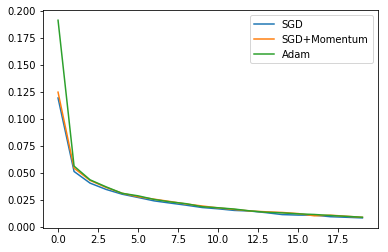

In [54]:
ax = plt.subplot(1,1,1)
ax.plot(loss_curve_sgd,label="SGD")
ax.plot(loss_curve_sgd_momentum,label="SGD+Momentum")
ax.plot(loss_curve_adam, label='Adam' )
ax.legend()

### Выводы
Тут нужно написать выводы по сравнению скорости сходимлости алгоритмов SGD, SGD + Momentum, ADAM для различных праметров
1. lr - коэффициент обучения для всех элгоритмов (0.1, 0.01, 0.001, 0.0001) при фиксированных остальных гиперпараметрах 
2. beta - для SGD + momentum (0,9, 0,99, 0,5) для лучшего графика в пункте 1.
3. beta1, beta2 - для ADAM - для различных значений (0,9, 0,99, 0,5) для лучшего графика в пункте 1.

TODO

## 1. Сравнение скорости сходимости для learning rate

In [61]:
lr = [0.1, 0.01, 0.001, 0.0001]

### SGD

Do epoch 0 with loss 1.182457398294476
Do epoch 1 with loss 0.4614004676452117
Do epoch 2 with loss 0.30279745341410197
Do epoch 3 with loss 0.23650228461079473
Do epoch 4 with loss 0.19845849823055062
Do epoch 5 with loss 0.1744851641217268
Do epoch 6 with loss 0.15639795156499814
Do epoch 7 with loss 0.1425996107080373
Do epoch 8 with loss 0.13191396302905975
Do epoch 9 with loss 0.12339998274414736
Do epoch 0 with loss 1.5581028231704512
Do epoch 1 with loss 0.6274720681656645
Do epoch 2 with loss 0.3682594279455005
Do epoch 3 with loss 0.2703595410506094
Do epoch 4 with loss 0.21948833494465483
Do epoch 5 with loss 0.18813886540457708
Do epoch 6 with loss 0.16620020239618635
Do epoch 7 with loss 0.15050536906495723
Do epoch 8 with loss 0.13791552675222774
Do epoch 9 with loss 0.12824515818316315
Do epoch 0 with loss 1.3904133347762901
Do epoch 1 with loss 0.5129674001540231
Do epoch 2 with loss 0.3145318782330922
Do epoch 3 with loss 0.24151326302706405
Do epoch 4 with loss 0.20106

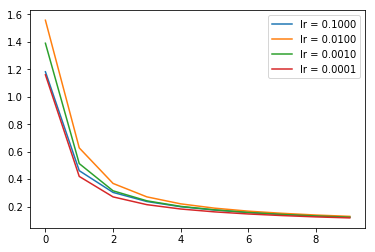

In [66]:
plt.figure()

for cur_lr in lr:
    net = Net(batchnorm=True)
    optimizer = SGD(net.parameters(), lr=learning_rate, beta=0.0)
    loss_curve_sgd = fit_net(10, net, optimizer)
    plt.plot(loss_curve_sgd,label='lr = %.4f' % cur_lr)
    
plt.legend()
plt.show()

**Вывод:** 
Наилучшая сходимость для данной модели наблюдается при коэффициенте обучения $lr = 0.0001$

## SGD + momentum

Do epoch 0 with loss 0.12223568090263653
Do epoch 1 with loss 0.052082308779705266
Do epoch 2 with loss 0.041545778931985994
Do epoch 3 with loss 0.0357143297369043
Do epoch 4 with loss 0.03073383381255533
Do epoch 5 with loss 0.026623602065666115
Do epoch 6 with loss 0.025910226577934632
Do epoch 7 with loss 0.023198156349725465
Do epoch 8 with loss 0.02150593445583953
Do epoch 9 with loss 0.019115652822581503
Do epoch 0 with loss 0.3205470420457644
Do epoch 1 with loss 0.10294237873075376
Do epoch 2 with loss 0.0787615336794585
Do epoch 3 with loss 0.06626610628064768
Do epoch 4 with loss 0.059159383865922455
Do epoch 5 with loss 0.05378933330962905
Do epoch 6 with loss 0.04911565370125263
Do epoch 7 with loss 0.04577243343765571
Do epoch 8 with loss 0.042654477828065175
Do epoch 9 with loss 0.040159678038092145
Do epoch 0 with loss 1.1529644729750965
Do epoch 1 with loss 0.3930977960332213
Do epoch 2 with loss 0.2511796408256658
Do epoch 3 with loss 0.19461729742371986
Do epoch 4 wi

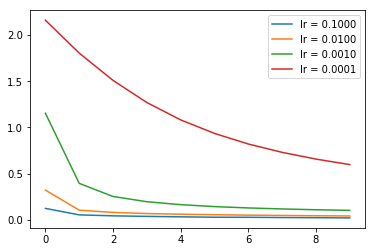

In [67]:
plt.figure()

for cur_lr in lr:
    net = Net(batchnorm=True)
    optimizer = SGD(net.parameters(), lr=cur_lr, beta=0.9)
    loss_curve_sgd_momentum = fit_net(10, net, optimizer)
    plt.plot(loss_curve_sgd_momentum,label='lr = %.4f' % cur_lr)
    
plt.legend()
plt.show()

**Вывод:**
В данном эксперименте графики наглядно демонстрируют, что наилучший параметр для данной модели - $lr = 0.1$

## ADAM

Do epoch 0 with loss 0.17412980922694124
Do epoch 1 with loss 0.05453947516819134
Do epoch 2 with loss 0.04180156064416087
Do epoch 3 with loss 0.03544676612728758
Do epoch 4 with loss 0.030600691429681304
Do epoch 5 with loss 0.027488440058224334
Do epoch 6 with loss 0.02445223384843837
Do epoch 7 with loss 0.02232471011120402
Do epoch 8 with loss 0.020254593032953478
Do epoch 9 with loss 0.0185519333337538
Do epoch 0 with loss 0.16941997710535336
Do epoch 1 with loss 0.05505430406946595
Do epoch 2 with loss 0.0431406377205965
Do epoch 3 with loss 0.0371079759878393
Do epoch 4 with loss 0.03321019660725774
Do epoch 5 with loss 0.02951304674279294
Do epoch 6 with loss 0.026166206933400424
Do epoch 7 with loss 0.023370655668195923
Do epoch 8 with loss 0.022112476866424875
Do epoch 9 with loss 0.02045717767663777
Do epoch 0 with loss 0.17948822227869204
Do epoch 1 with loss 0.055667610391020556
Do epoch 2 with loss 0.043302429746282824
Do epoch 3 with loss 0.036096672783211846
Do epoch 4

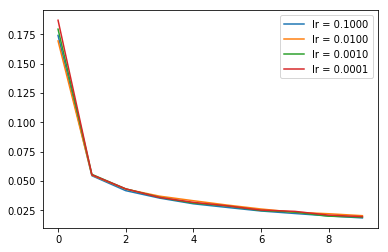

In [65]:
plt.figure()

for cur_lr in lr:
    net = Net(batchnorm=True)
    optimizer = Adam(net.parameters(), lr=learning_rate, betas=(0.9, 0.999))
    loss_curve_adam = fit_net(10, net, optimizer)
    plt.plot(loss_curve_adam,label='lr = %.4f' % cur_lr)
    
plt.legend()
plt.show()

**Вывод:**
В данном слушае наилучший результат получается при коэффециенте обучения $lr = 0.1$

## 2. Сравнение скорости сходимости для beta в SGD + momentum

Do epoch 0 with loss 0.12101502637504495
Do epoch 1 with loss 0.05086381131443304
Do epoch 2 with loss 0.04057914859418952
Do epoch 3 with loss 0.03357259485620203
Do epoch 4 with loss 0.028986582567444335
Do epoch 5 with loss 0.026789196298909503
Do epoch 6 with loss 0.02371876305935859
Do epoch 7 with loss 0.021225586642562716
Do epoch 8 with loss 0.01978447641385272
Do epoch 9 with loss 0.019106062399125504
Do epoch 0 with loss 0.12586883034098895
Do epoch 1 with loss 0.053765532421395285
Do epoch 2 with loss 0.04254543748234961
Do epoch 3 with loss 0.03655680919693767
Do epoch 4 with loss 0.031215012983121335
Do epoch 5 with loss 0.028328406923864877
Do epoch 6 with loss 0.025541725796300305
Do epoch 7 with loss 0.024078972191368002
Do epoch 8 with loss 0.021640400810633068
Do epoch 9 with loss 0.019741025757151868
Do epoch 0 with loss 0.1373185811740626
Do epoch 1 with loss 0.05488541884800044
Do epoch 2 with loss 0.042795787207274665
Do epoch 3 with loss 0.03599376641435333
Do ep

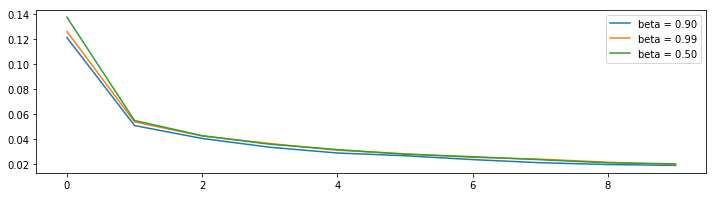

In [68]:
plt.figure(figsize=(12, 3))

beta = [0.9, 0.99, 0.5]

for cur_beta in beta:
    net = Net(batchnorm=True)
    optimizer = SGD(net.parameters(), lr=0.1, beta=cur_beta)
    loss_curve_sgd_momentum = fit_net(10, net, optimizer)
    plt.plot(loss_curve_sgd_momentum,label='beta = %.2f' % cur_beta)
    
plt.legend()
plt.show()

**Вывод:**
В данном эксперименте наилучшую скорость сходимости получили для $beta = 0.9$

## 3. Сравнение скорости сходимости для beta1, beta2 в ADAM

Do epoch 0 with loss 0.5132925648976392
Do epoch 1 with loss 0.3801283856004708
Do epoch 2 with loss 0.36202728515043753
Do epoch 3 with loss 0.35736900868782606
Do epoch 4 with loss 0.35154141345332623
Do epoch 5 with loss 0.34440440562424673
Do epoch 6 with loss 0.34722035795545597
Do epoch 7 with loss 0.3442274252549802
Do epoch 8 with loss 0.3394407196235292
Do epoch 9 with loss 0.33459030048837385
Do epoch 0 with loss 0.29675138034318266
Do epoch 1 with loss 0.2391490000059507
Do epoch 2 with loss 0.22021444952332597
Do epoch 3 with loss 0.2028614034597086
Do epoch 4 with loss 0.21829863807981112
Do epoch 5 with loss 0.20416292024880245
Do epoch 6 with loss 0.19322216795769337
Do epoch 7 with loss 0.18866336242405243
Do epoch 8 with loss 0.17826216520782462
Do epoch 9 with loss 0.1726169393269156
Do epoch 0 with loss 35530.347554323416
Do epoch 1 with loss 20034.317573566877
Do epoch 2 with loss 2.317245068046455
Do epoch 3 with loss 2.3200074166645455
Do epoch 4 with loss 2.31821

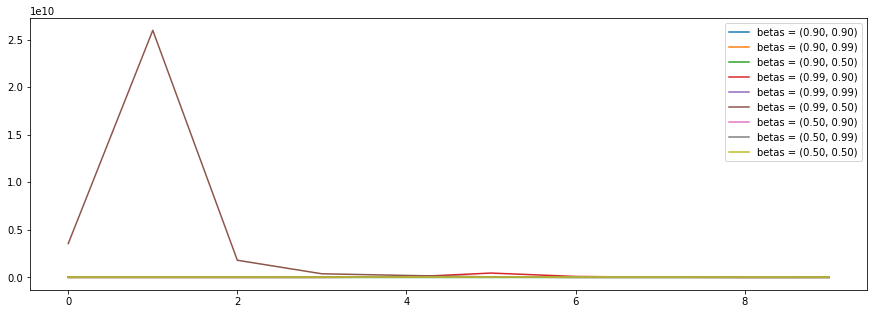

In [73]:
betas = [(0.9, 0.9), (0.9, 0.99), (0.9, 0.5), (0.99, 0.9), (0.99, 0.99), (0.99, 0.5), (0.5, 0.9), (0.5, 0.99), (0.5, 0.5)]

plt.figure(figsize=(15, 5))

for pair in betas:
    net = Net(batchnorm=True)
    optimizer = Adam(net.parameters(), lr=0.1, betas=pair)
    loss_curve_adam = fit_net(10, net, optimizer)
    plt.plot(loss_curve_adam,label='betas = (%.2f, %.2f)' % pair)
    
plt.legend()
plt.show()

**Вывод:** 
Наилучшая сходимость для алгоритма ADAM при коэффициенте обучения $lr = 0.1$ достигается при $(beta1, beta2) = (0.9, 0.99)$